# House Price

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import RobustScaler

## Load the Dataset:

In [8]:
# Load the dataset
df = pd.read_csv('American_Housing_Data_20231209.csv')

# Display the first few rows of the dataset
print(df.head())

# Display basic information about the dataset
print(df.info())

# Display summary statistics
print(df.describe())

   Zip Code      Price  Beds  Baths  Living Space                Address  \
0     10013  3999000.0     2      3          1967      74 GRAND ST APT 3   
1     10013  3999000.0     2      3          1967      74 GRAND ST APT 3   
2     10014  1650000.0     1      1           718  140 CHARLES ST APT 4D   
3     10014   760000.0     3      2          1538            38 JONES ST   
4     10014  1100000.0     1      1           600   81 BEDFORD ST APT 3F   

       City     State  Zip Code Population  Zip Code Density    County  \
0  New York  New York                29563           20967.9  New York   
1  New York  New York                29563           20967.9  New York   
2  New York  New York                29815           23740.9  New York   
3  New York  New York                29815           23740.9  New York   
4  New York  New York                29815           23740.9  New York   

   Median Household Income  Latitude  Longitude  
0                 370046.0  40.72001  -74.00472 

## Data Cleaning

In [9]:
# Drop duplicates
df = df.drop_duplicates()

# Fill missing values for 'Median Household Income'
df['Median Household Income'] = df['Median Household Income'].fillna(df['Median Household Income'].median())

# Drop unnecessary columns
df = df.drop(['Address', 'City', 'State'], axis=1, errors='ignore')

# Cap extreme outliers for 'Beds' and 'Baths'
df['Beds'] = df['Beds'].clip(lower=1, upper=10)
df['Baths'] = df['Baths'].clip(lower=1, upper=10)

# Feature Engineering
df['Log_Price'] = np.log(df['Price'])
df['Price per Sqft'] = df['Price'] / df['Living Space']

# One-hot encode the 'County' column
df = pd.get_dummies(df, columns=['County'], drop_first=True, dummy_na=False)

# Define numeric columns for outlier removal
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns  # Select only numeric columns

# Remove outliers using the IQR method
Q1 = df[numeric_columns].quantile(0.25)
Q3 = df[numeric_columns].quantile(0.75)
IQR = Q3 - Q1

# Filter out outliers
df = df[~((df[numeric_columns] < (Q1 - 1.5 * IQR)) | (df[numeric_columns] > (Q3 + 1.5 * IQR))).any(axis=1)]

# Check for any remaining missing values
print(df.isnull().sum())

Zip Code             0
Price                0
Beds                 0
Baths                0
Living Space         0
                    ..
County_Wake          0
County_Washington    0
County_Wayne         0
County_Williamson    0
County_Wyandotte     0
Length: 99, dtype: int64


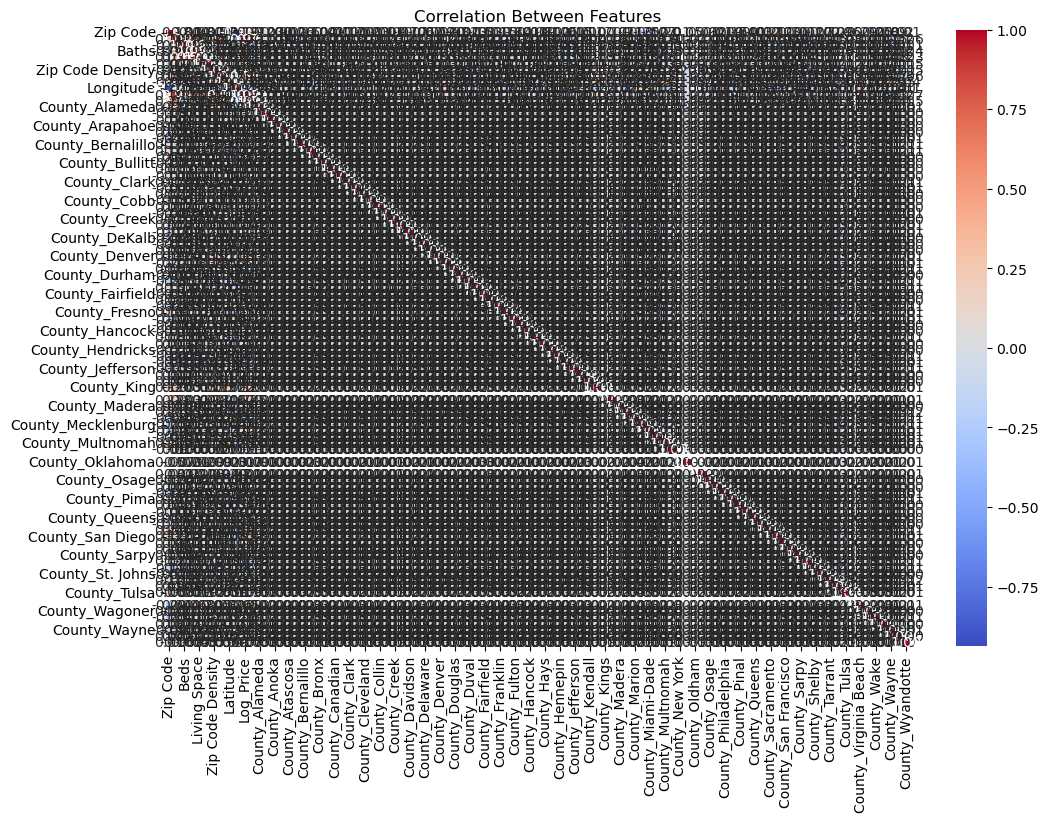

In [10]:
# Feature Selection: Correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Between Features')
plt.show()

# Define features (X) and target (y)
X = df.drop(['Price', 'Log_Price'], axis=1)  # Drop target variables from features
y = df['Log_Price']  # We will use the log-transformed price as the target variable

## Basic Exploratory Data Analysis (EDA)

In [11]:
print(df.describe())

           Zip Code         Price          Beds         Baths  Living Space  \
count  28293.000000  2.829300e+04  28293.000000  28293.000000  28293.000000   
mean   64227.069947  4.079299e+05      3.153501      2.326370   1764.390238   
std    23964.193867  2.239706e+05      0.794846      0.798351    646.596668   
min    10301.000000  6.700000e+04      2.000000      1.000000    100.000000   
25%    40291.000000  2.500000e+05      3.000000      2.000000   1271.000000   
50%    73162.000000  3.590000e+05      3.000000      2.000000   1646.000000   
75%    85029.000000  5.120840e+05      4.000000      3.000000   2144.000000   
max    98199.000000  1.275000e+06      5.000000      4.000000   3859.000000   

       Zip Code Population  Zip Code Density  Median Household Income  \
count         28293.000000      28293.000000             28293.000000   
mean          36965.437493       1591.576266            100772.189906   
std           17056.156407       1083.309747             35673.920070

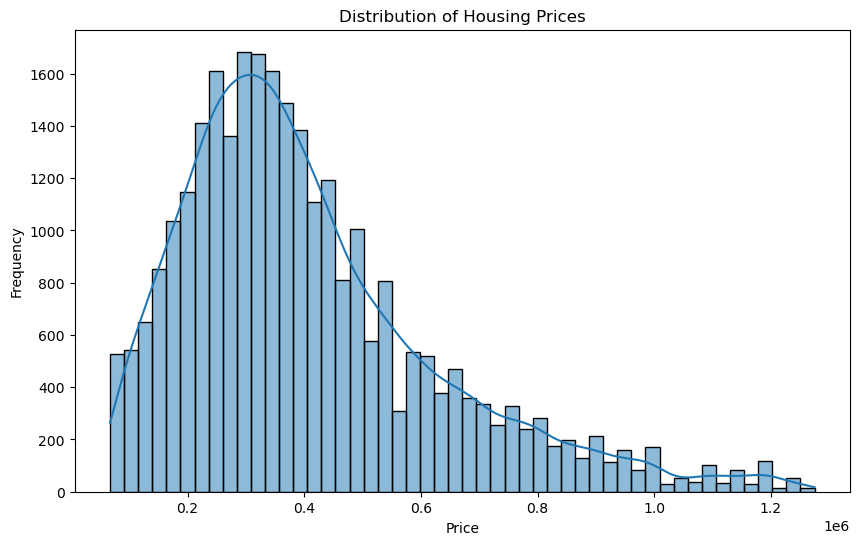

In [12]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Price'], kde=True, bins=50)
plt.title('Distribution of Housing Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

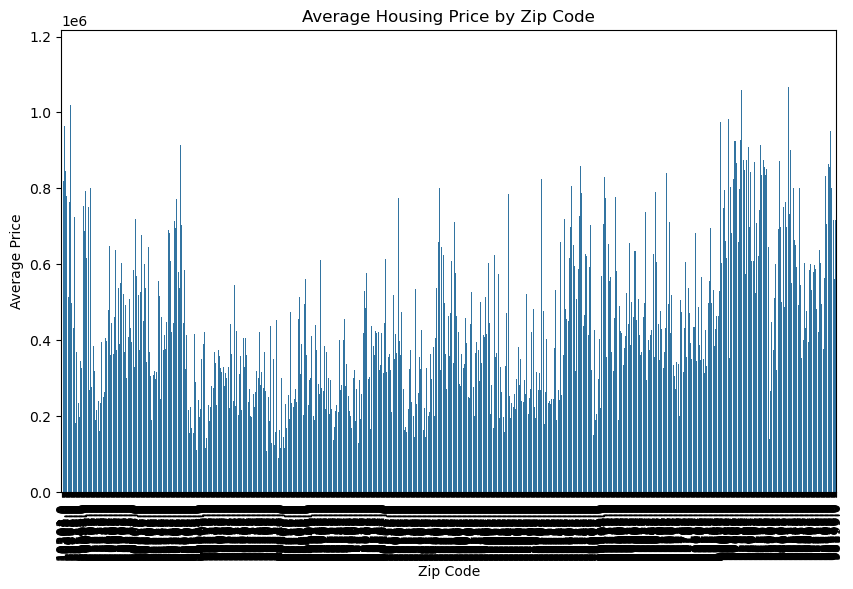

In [13]:
# Group by 'Zip Code' and calculate the mean for numeric columns only
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns  # Select only numeric columns
df_grouped = df.groupby('Zip Code', as_index=False)[numeric_columns].mean()

# Now plot the average housing price by Zip Code
plt.figure(figsize=(10, 6))
sns.barplot(x='Zip Code', y='Price', data=df_grouped)
plt.xticks(rotation=90)
plt.title('Average Housing Price by Zip Code')
plt.xlabel('Zip Code')
plt.ylabel('Average Price')
plt.show()

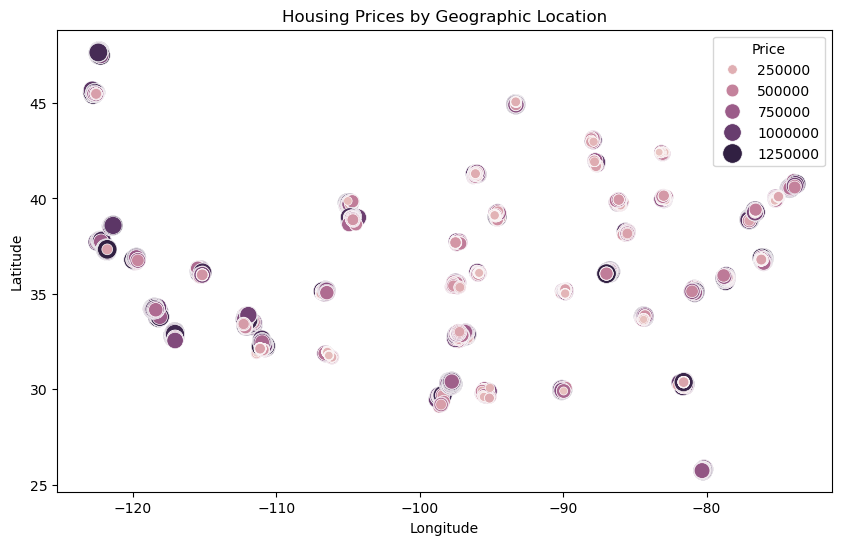

In [14]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Longitude', y='Latitude', hue='Price', size='Price', sizes=(20, 200), data=df)
plt.title('Housing Prices by Geographic Location')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

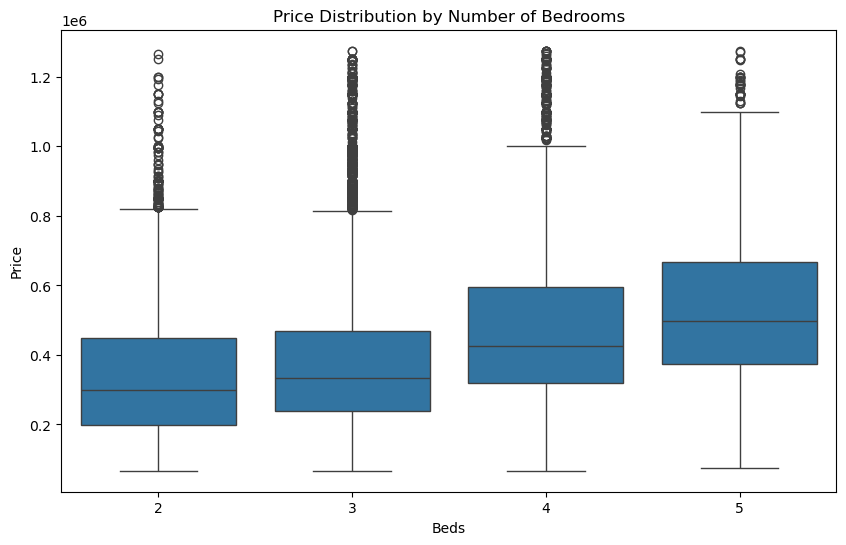

In [15]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Beds', y='Price', data=df)
plt.title('Price Distribution by Number of Bedrooms')
plt.show()

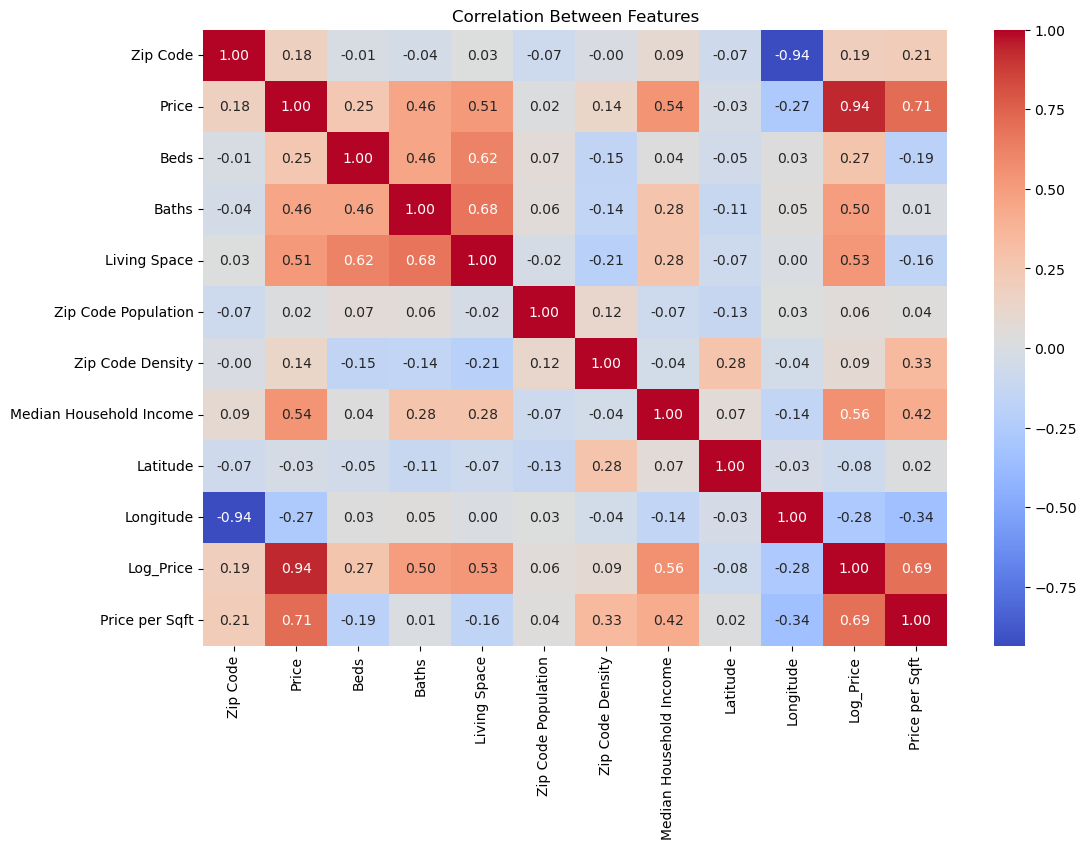

In [16]:
# Select only the numeric columns for the correlation matrix
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Plot the heatmap for the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Between Features')
plt.show()

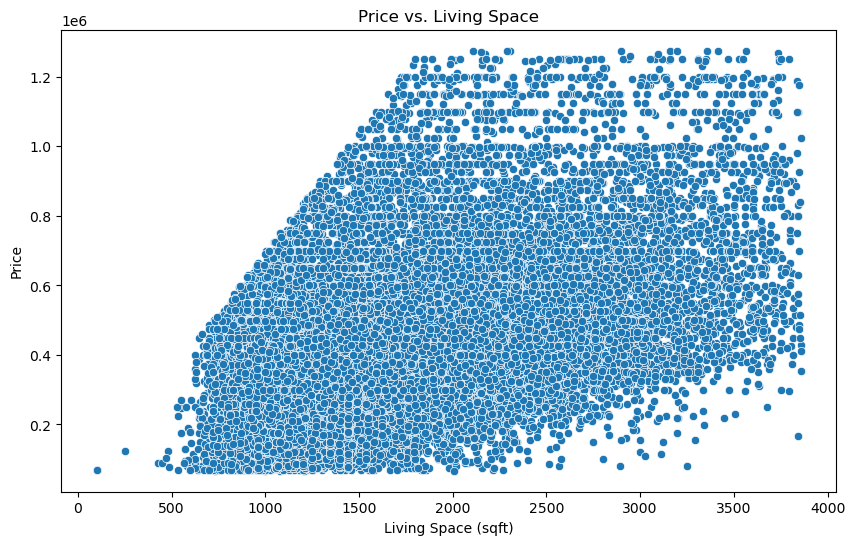

In [17]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Living Space', y='Price', data=df)
plt.title('Price vs. Living Space')
plt.xlabel('Living Space (sqft)')
plt.ylabel('Price')
plt.show()

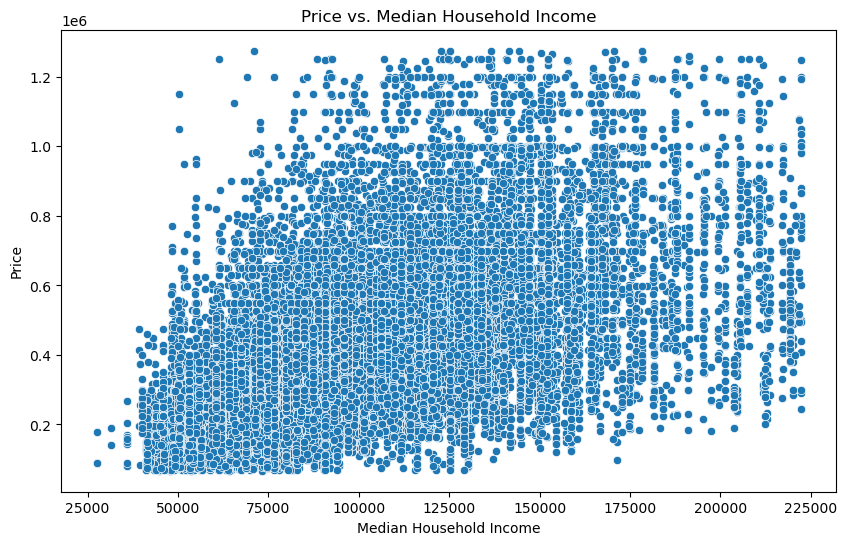

In [18]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Median Household Income', y='Price', data=df)
plt.title('Price vs. Median Household Income')
plt.xlabel('Median Household Income')
plt.ylabel('Price')
plt.show()

In [19]:
# Handling Correlation Issues (Remove highly correlated features)

# Calculate correlation matrix
corr_matrix = df.corr()

# Identify highly correlated features (|correlation| > 0.9)
high_corr_features = corr_matrix[corr_matrix > 0.9].stack().index.tolist()
print(f"Highly correlated features: {high_corr_features}")

Highly correlated features: [('Zip Code', 'Zip Code'), ('Price', 'Price'), ('Price', 'Log_Price'), ('Beds', 'Beds'), ('Baths', 'Baths'), ('Living Space', 'Living Space'), ('Zip Code Population', 'Zip Code Population'), ('Zip Code Density', 'Zip Code Density'), ('Median Household Income', 'Median Household Income'), ('Latitude', 'Latitude'), ('Longitude', 'Longitude'), ('Log_Price', 'Price'), ('Log_Price', 'Log_Price'), ('Price per Sqft', 'Price per Sqft'), ('County_Alameda', 'County_Alameda'), ('County_Anne Arundel', 'County_Anne Arundel'), ('County_Anoka', 'County_Anoka'), ('County_Arapahoe', 'County_Arapahoe'), ('County_Atascosa', 'County_Atascosa'), ('County_Baltimore', 'County_Baltimore'), ('County_Bernalillo', 'County_Bernalillo'), ('County_Bexar', 'County_Bexar'), ('County_Bronx', 'County_Bronx'), ('County_Bullitt', 'County_Bullitt'), ('County_Canadian', 'County_Canadian'), ('County_Chesapeake', 'County_Chesapeake'), ('County_Clark', 'County_Clark'), ('County_Clay', 'County_Clay'

## Train a Linear Regression Model

In [20]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing the Data using RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred_linear = linear_model.predict(X_test_scaled)

# Evaluate the Linear Regression model
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

print(f"Linear Regression - Mean Squared Error: {mse_linear}")
print(f"Linear Regression - R-squared Score: {r2_linear}")

# Initialize and fit the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred_rf = rf_model.predict(X_test_scaled)

# Evaluate the Random Forest model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest - Mean Squared Error: {mse_rf}")
print(f"Random Forest - R-squared Score: {r2_rf}")

Linear Regression - Mean Squared Error: 0.02144749005847077
Linear Regression - R-squared Score: 0.9329178126316643
Random Forest - Mean Squared Error: 0.00032250280222644837
Random Forest - R-squared Score: 0.9989912948626255


## Test Your Prediction

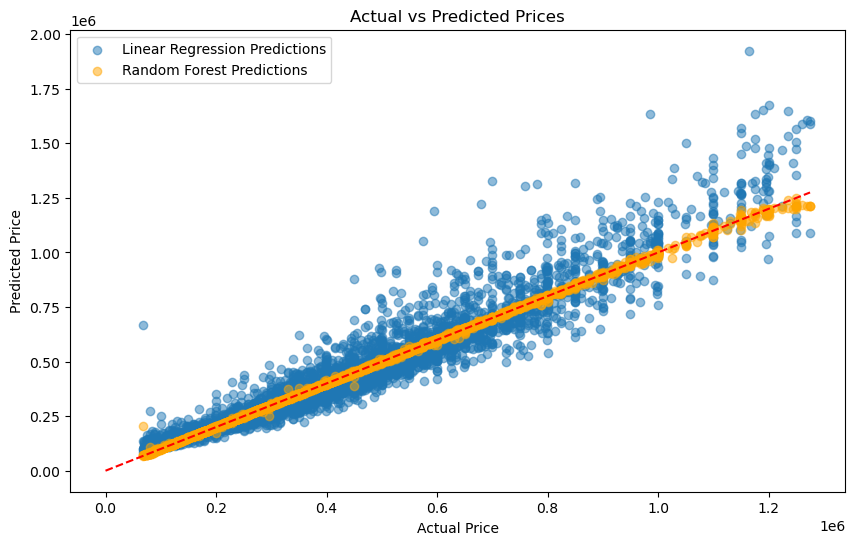

Mean Absolute Error for Linear Regression:  42728.39111989327
Mean Absolute Error for Random Forest:  2006.4453473163637


In [21]:
# Inverse transform to get actual prices from log prices
y_test_actual = np.exp(y_test)
y_pred_linear_actual = np.exp(y_pred_linear)
y_pred_rf_actual = np.exp(y_pred_rf)

# Visualization
plt.figure(figsize=(10, 6))
plt.scatter(y_test_actual, y_pred_linear_actual, alpha=0.5, label='Linear Regression Predictions')
plt.scatter(y_test_actual, y_pred_rf_actual, alpha=0.5, label='Random Forest Predictions', color='orange')
plt.plot([0, max(y_test_actual)], [0, max(y_test_actual)], 'r--')  # 45-degree line
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices')
plt.legend()
plt.show()

# Calculate and print prediction errors for a more quantitative analysis
linear_errors = np.abs(y_test_actual - y_pred_linear_actual)
rf_errors = np.abs(y_test_actual - y_pred_rf_actual)

print("Mean Absolute Error for Linear Regression: ", np.mean(linear_errors))
print("Mean Absolute Error for Random Forest: ", np.mean(rf_errors))

Feature ranking:
1. Price per Sqft (0.618917107602613)
2. Living Space (0.38027453977332004)
3. Median Household Income (0.000315384088948226)
4. County_Shelby (0.00011169988761425181)
5. Zip Code Population (6.05125099151509e-05)
6. Zip Code Density (5.825236214779524e-05)
7. Latitude (5.6816150559830905e-05)
8. Zip Code (5.00660388659104e-05)
9. Longitude (4.728271483435802e-05)
10. Beds (1.4203930680609593e-05)
11. County_Baltimore (1.3935953713172361e-05)
12. Baths (1.2399105932979812e-05)
13. County_Maricopa (5.697468081662941e-06)
14. County_Jackson (3.646186385038314e-06)
15. County_Bexar (2.919500707306867e-06)
16. County_Sedgwick (2.836342966394426e-06)
17. County_Jefferson (2.7710259454751107e-06)
18. County_Wayne (2.6823390880537443e-06)
19. County_Duval (2.2904115466271376e-06)
20. County_Orleans (2.27598459648321e-06)
21. County_Marion (2.0457371574232807e-06)
22. County_Tulsa (2.0008690395658504e-06)
23. County_El Paso (1.943130042650337e-06)
24. County_Tarrant (1.8998534

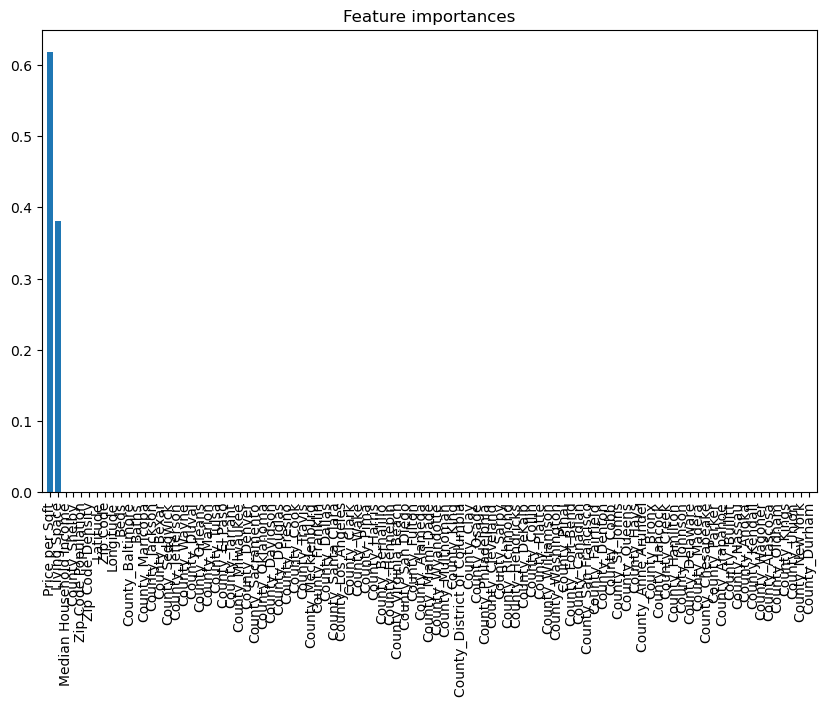

In [22]:
# Analyze Feature Importance

# Feature importance for Random Forest
importances = rf_model.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{f + 1}. {feature_names[indices[f]]} ({importances[indices[f]]})")

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

## Visualize the Results

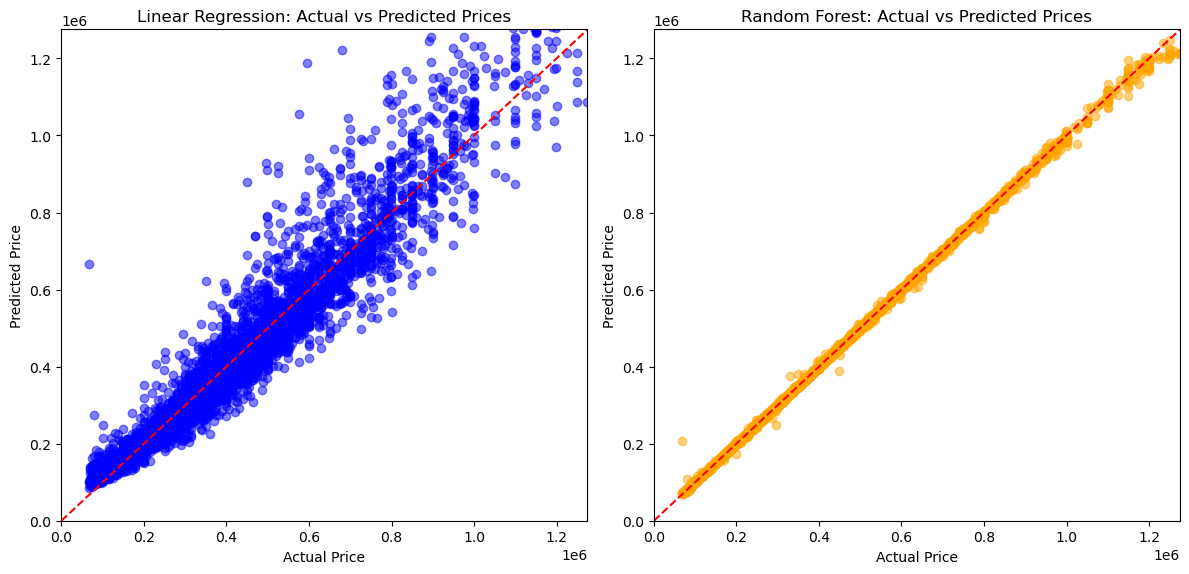

In [23]:
# Inverse transform to get actual prices from log prices
y_test_actual = np.exp(y_test)
y_pred_linear_actual = np.exp(y_pred_linear)
y_pred_rf_actual = np.exp(y_pred_rf)

# Visualization of Actual vs Predicted Prices
plt.figure(figsize=(12, 6))

# Scatter plot for Linear Regression
plt.subplot(1, 2, 1)
plt.scatter(y_test_actual, y_pred_linear_actual, alpha=0.5, color='blue')
plt.plot([0, max(y_test_actual)], [0, max(y_test_actual)], 'r--')  # 45-degree line
plt.title('Linear Regression: Actual vs Predicted Prices')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.xlim(0, max(y_test_actual))
plt.ylim(0, max(y_test_actual))

# Scatter plot for Random Forest
plt.subplot(1, 2, 2)
plt.scatter(y_test_actual, y_pred_rf_actual, alpha=0.5, color='orange')
plt.plot([0, max(y_test_actual)], [0, max(y_test_actual)], 'r--')  # 45-degree line
plt.title('Random Forest: Actual vs Predicted Prices')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.xlim(0, max(y_test_actual))
plt.ylim(0, max(y_test_actual))

plt.tight_layout()
plt.show()